In [11]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error,root_mean_squared_log_error,mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("formatted_data.csv")
IQR_SIZE = 74 - 43
size_outliers_upper = 74 + 1.5*IQR_SIZE
size_outliers_lower = 43.3 - 1.5*IQR_SIZE
IQR_PRICE = 1330000 - 729000
price_outliers_upper = 1330000 + 1.5*IQR_PRICE
price_outliers_lower = 729000 - 1.5*IQR_PRICE

IQR_RENT = 1090 - 612
rent_outliers_upper = 1090 + 1.5*IQR_RENT
rent_outliers_lower = 612 - 1.5*IQR_RENT

# deleting outliers to check their importance to the models
# w_o meaning without outliers
df_w_o = df[(df['rozmiar'].between(size_outliers_lower,size_outliers_upper)) 
        & (df['czynsz'].between(rent_outliers_lower,rent_outliers_upper)) 
        & (df['cena'].between(price_outliers_lower,price_outliers_upper)) ]

In [13]:
df['MSI'].unique()

array(['0', 'Tarchomin', 'Koło', 'Stegny', 'Pelcowizna',
       'Dąbrówka Szlachecka', 'Służew', 'Grochów', 'Służewiec',
       'Wawrzyszew', 'Wierzbno', 'Filtry', 'Zawady', 'Powsinek',
       'Stare Miasto', 'Saska Kępa', 'Ujazdów', 'Śródmieście Południowe',
       'Nowodwory', 'Powązki', 'Wyględów', 'Czerniaków', 'Stary Żoliborz',
       'Targówek Mieszkaniowy', 'Brzeziny', 'Ursynów-Centrum', 'Odolany',
       'Śródmieście Północne', 'Mirów', 'Sielce', 'Młynów', 'Sadyba',
       'Ksawerów', 'Kawęczyn-Wygoda', 'Chomiczówka', 'Chrzanów',
       'Błonia Wilanowskie', 'Nowa Praga', 'Wilanów Wysoki',
       'Bródno-Podgrodzie', 'Grodzisk', 'Gocław', 'Stary Mokotów',
       'Stara Ochota', 'Nowe Miasto', 'Sady Żoliborskie', 'Kobiałka',
       'Kabaty', 'Bemowo-Lotnisko', 'Salomea', 'Piaski', 'Gołąbki',
       'Zielona-Grzybowa', 'Natolin', 'Plac Wojska Polskiego', 'Wyczółki',
       'Szmulowizna', 'Bródno', 'Czyste', 'Stare Bielany', 'Stare Włochy',
       'Powiśle', 'Górce', 'Jeziorki Poł

In [14]:
dummies_df = pd.get_dummies(df.drop('ulica',axis=1), dtype=int)
dummies_df_w_o = pd.get_dummies(df_w_o.drop('ulica',axis=1), dtype=int)

In [15]:
scaler = StandardScaler()
X = dummies_df.drop('cena',axis=1)
y = dummies_df['cena']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_trans =scaler.fit_transform(X_train)
X_test_trans =scaler.transform(X_test)

X_W_O= dummies_df_w_o.drop('cena',axis=1)
y_w_o = dummies_df_w_o['cena']

X_train_w_o, X_test_w_o, y_train_w_o, y_test_w_o = train_test_split(X_W_O, y_w_o, test_size=0.2, random_state=42)
X_train_trans_w_o =scaler.fit_transform(X_train_w_o)
X_test_trans_w_o =scaler.transform(X_test_w_o)

In [16]:
# result tables
RMSE = []
RMSLE = []
MAPE = []

# Defining Functions

In [17]:
def getFittedModelWithScore(model,x_train,x_test,y_train,y_test,data):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    RMSE.append(f'{model.__class__.__name__} RMSE score on {data}: {root_mean_squared_error(y_test,y_pred)}')
    RMSLE.append(f'{model.__class__.__name__} RMSLE score on {data}: {root_mean_squared_log_error(y_test,y_pred)}')
    MAPE.append(f'{model.__class__.__name__} MAPE score on {data}: {mean_absolute_percentage_error(y_test,y_pred)}')
    return model

In [18]:
def addResultsForHybridModel(y_test,y_pred,data):
    RMSE.append(f'Hybrid Model RMSE score on {data}: {root_mean_squared_error(y_test,y_pred)}')
    RMSLE.append(f'Hybrid Model RMSLE score on {data}: {root_mean_squared_log_error(y_test,y_pred)}')
    MAPE.append(f'Hybrid Model MAPE score on {data}: {mean_absolute_percentage_error(y_test,y_pred)}')

In [52]:
def getPlotForFeatureScores(x,model):
    feats = pd.DataFrame(index=x.columns,data=model.feature_importances_,columns=['Importance'])
    imp_feats = feats[feats['Importance']>0.01]
    imp_feats = imp_feats.sort_values("Importance")
    plt.figure(figsize=(2400/96,1200/96),facecolor='white')
    sns.barplot(data=imp_feats.sort_values('Importance'),x=imp_feats.sort_values('Importance').index,y='Importance',palette='viridis',hue=imp_feats.sort_values('Importance').index);
    #plt.xticks(rotation=45);
    plt.xlabel("")
    plt.savefig(f'{model.__class__.__name__}-feature-imp.png', dpi=96,bbox_inches='tight')

# Creating Models

In [20]:
rf_1 = RandomForestRegressor(n_estimators=200,criterion='squared_error',max_features=0.33,max_depth=15)
rf_2 = RandomForestRegressor(n_estimators=200,criterion='friedman_mse',max_features=0.33,max_depth=15)
rf_3 = RandomForestRegressor(n_estimators=200,criterion='friedman_mse',max_features=0.33,max_depth=15)
rf_4 = RandomForestRegressor(n_estimators=200,criterion='squared_error',max_features=0.33,max_depth=15)

rf_1 = getFittedModelWithScore(rf_1,X_train,X_test,y_train,y_test,"unscaled data with outliers")
rf_2 = getFittedModelWithScore(rf_2,X_train_trans,X_test_trans,y_train,y_test,"scaled data with outliers")
rf_3 = getFittedModelWithScore(rf_3,X_train_w_o,X_test_w_o,y_train_w_o,y_test_w_o,"unscaled data without outliers")
rf_4 = getFittedModelWithScore(rf_4,X_train_trans_w_o,X_test_trans_w_o,y_train_w_o,y_test_w_o,"scaled data without outliers")

In [21]:
dtForAdaBoost = DecisionTreeRegressor(max_depth=15,max_features=0.33)
ab_1 = AdaBoostRegressor(dtForAdaBoost, learning_rate= 0.01, loss= 'exponential', n_estimators= 100)
ab_2 = AdaBoostRegressor(dtForAdaBoost, learning_rate= 0.01, loss= 'exponential', n_estimators= 100)
ab_3 = AdaBoostRegressor(dtForAdaBoost, learning_rate= 0.01, loss= 'exponential', n_estimators= 100)
ab_4 = AdaBoostRegressor(dtForAdaBoost, learning_rate=0.001, loss='square', n_estimators=100)

ab_1 = getFittedModelWithScore(ab_1,X_train,X_test,y_train,y_test,"unscaled data with outliers")
ab_2 = getFittedModelWithScore(ab_2,X_train_trans,X_test_trans,y_train,y_test,"scaled data with outliers")
ab_3 = getFittedModelWithScore(ab_3,X_train_w_o,X_test_w_o,y_train_w_o,y_test_w_o,"unscaled data without outliers")
ab_4 = getFittedModelWithScore(ab_4,X_train_trans_w_o,X_test_trans_w_o,y_train_w_o,y_test_w_o,"scaled data without outliers")

In [22]:
gb_1 = GradientBoostingRegressor(n_estimators=300,learning_rate=0.01,loss='squared_error',max_depth=10)
gb_2 = GradientBoostingRegressor(n_estimators=300,learning_rate=0.01,loss='squared_error',max_depth=10)
gb_3 = GradientBoostingRegressor(n_estimators=300,learning_rate=0.01,loss='squared_error',max_depth=10)
gb_4 = GradientBoostingRegressor(n_estimators=300,learning_rate=0.01,loss='squared_error',max_depth=10)

gb_1 = getFittedModelWithScore(gb_1,X_train,X_test,y_train,y_test,"unscaled data with outliers")
gb_2 = getFittedModelWithScore(gb_2,X_train_trans,X_test_trans,y_train,y_test,"scaled data with outliers")
gb_3 = getFittedModelWithScore(gb_3,X_train_w_o,X_test_w_o,y_train_w_o,y_test_w_o,"unscaled data without outliers")
gb_4 = getFittedModelWithScore(gb_4,X_train_trans_w_o,X_test_trans_w_o,y_train_w_o,y_test_w_o,"scaled data without outliers")

In [23]:
svr_1 = SVR(C=5000000,epsilon=5e-07,gamma='scale',kernel='rbf')
svr_2 = SVR(C=5000000,epsilon=5e-07,gamma='auto',kernel='rbf')
svr_3 = SVR(C=5000000,epsilon=1e-06,gamma='scale',kernel='rbf')
svr_4 = SVR(C=5000000,epsilon=1e-06,gamma='auto',kernel='rbf')

svr_1 = getFittedModelWithScore(svr_1,X_train,X_test,y_train,y_test,"unscaled data with outliers")
svr_2 = getFittedModelWithScore(svr_2,X_train_trans,X_test_trans,y_train,y_test,"scaled data with outliers")
svr_3 = getFittedModelWithScore(svr_3,X_train_w_o,X_test_w_o,y_train_w_o,y_test_w_o,"unscaled data without outliers")
svr_4 = getFittedModelWithScore(svr_4,X_train_trans_w_o,X_test_trans_w_o,y_train_w_o,y_test_w_o,"scaled data without outliers")

In [24]:
y_pred_combined_1 = (rf_1.predict(X_test)+ab_1.predict(X_test)+gb_1.predict(X_test)+svr_1.predict(X_test))/4
y_pred_combined_2 = (rf_2.predict(X_test_trans)+ab_2.predict(X_test_trans)+gb_2.predict(X_test_trans)+svr_2.predict(X_test_trans))/4
y_pred_combined_3 = (rf_3.predict(X_test_w_o)+ab_3.predict(X_test_w_o)+gb_3.predict(X_test_w_o)+svr_3.predict(X_test_w_o))/4
y_pred_combined_4 = (rf_4.predict(X_test_trans_w_o)+ab_4.predict(X_test_trans_w_o)+gb_4.predict(X_test_trans_w_o)+svr_4.predict(X_test_trans_w_o))/4

addResultsForHybridModel(y_test,y_pred_combined_1,"unscaled data with outliers")
addResultsForHybridModel(y_test,y_pred_combined_2,"scaled data with outliers")
addResultsForHybridModel(y_test_w_o,y_pred_combined_3,"unscaled data without outliers")
addResultsForHybridModel(y_test_w_o,y_pred_combined_4,"scaled data without outliers")

# Feature Selection

the tree models have implemented scoring system for each of the features used. We will be creating a plot of values of scores that are bigger than 0.01. SVR and hybrid model doesn't have implemented scoring system, so they will me omitted from this point. The data will be fitted on models with scaled data without outliers as they were the best scoring.

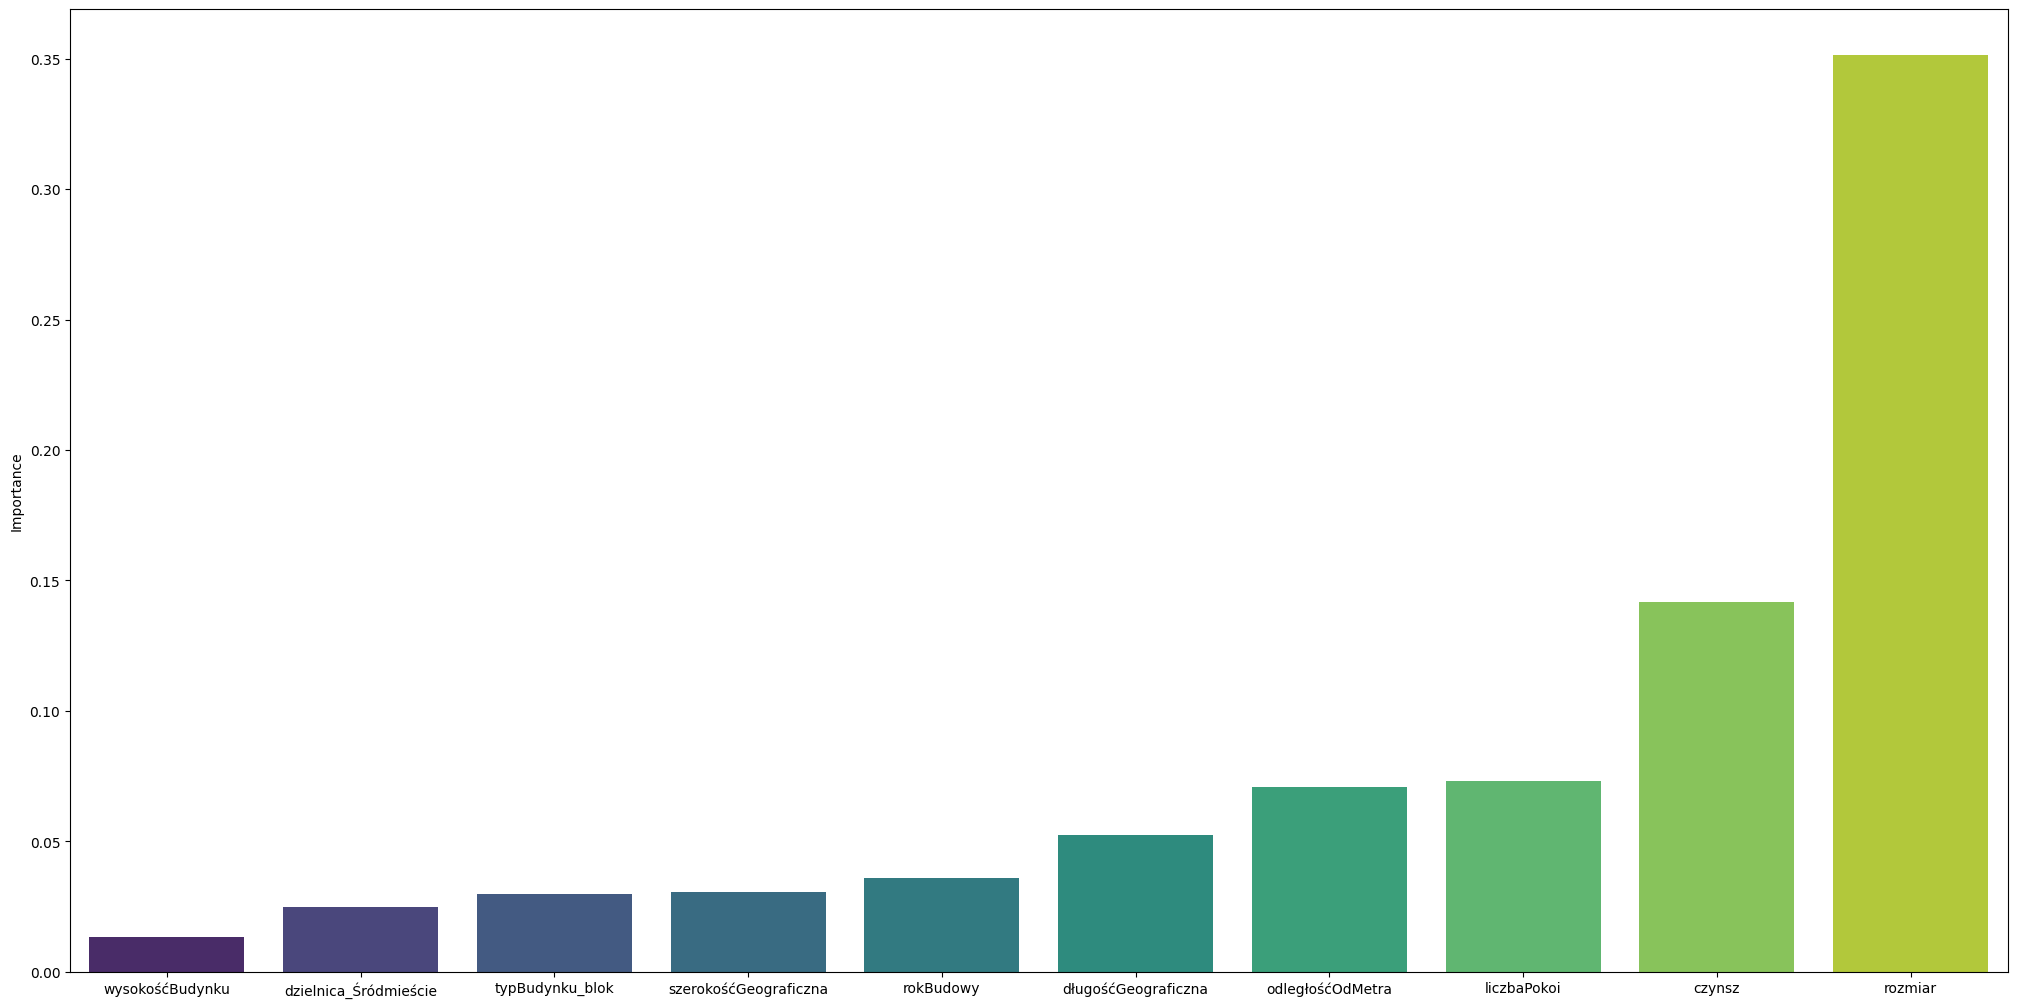

In [53]:
getPlotForFeatureScores(X_W_O,rf_4)

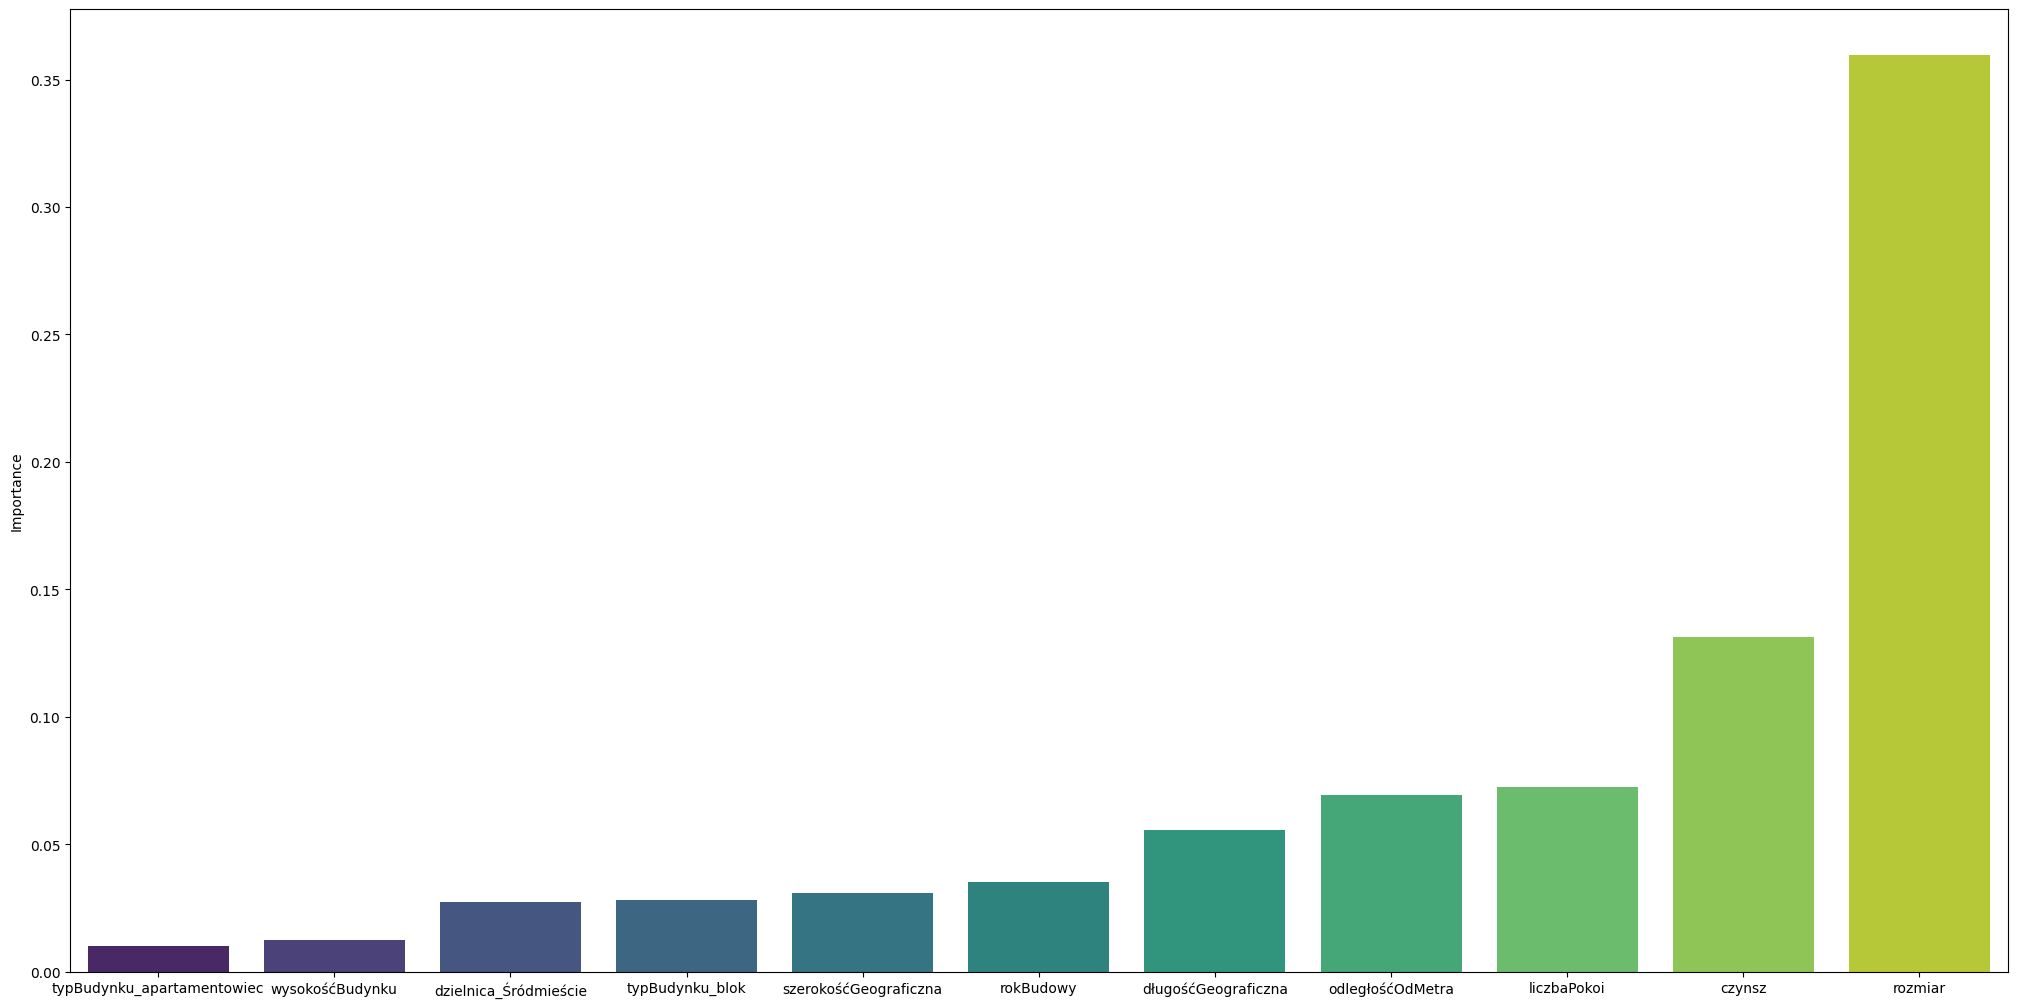

In [54]:
getPlotForFeatureScores(X_W_O,ab_4)

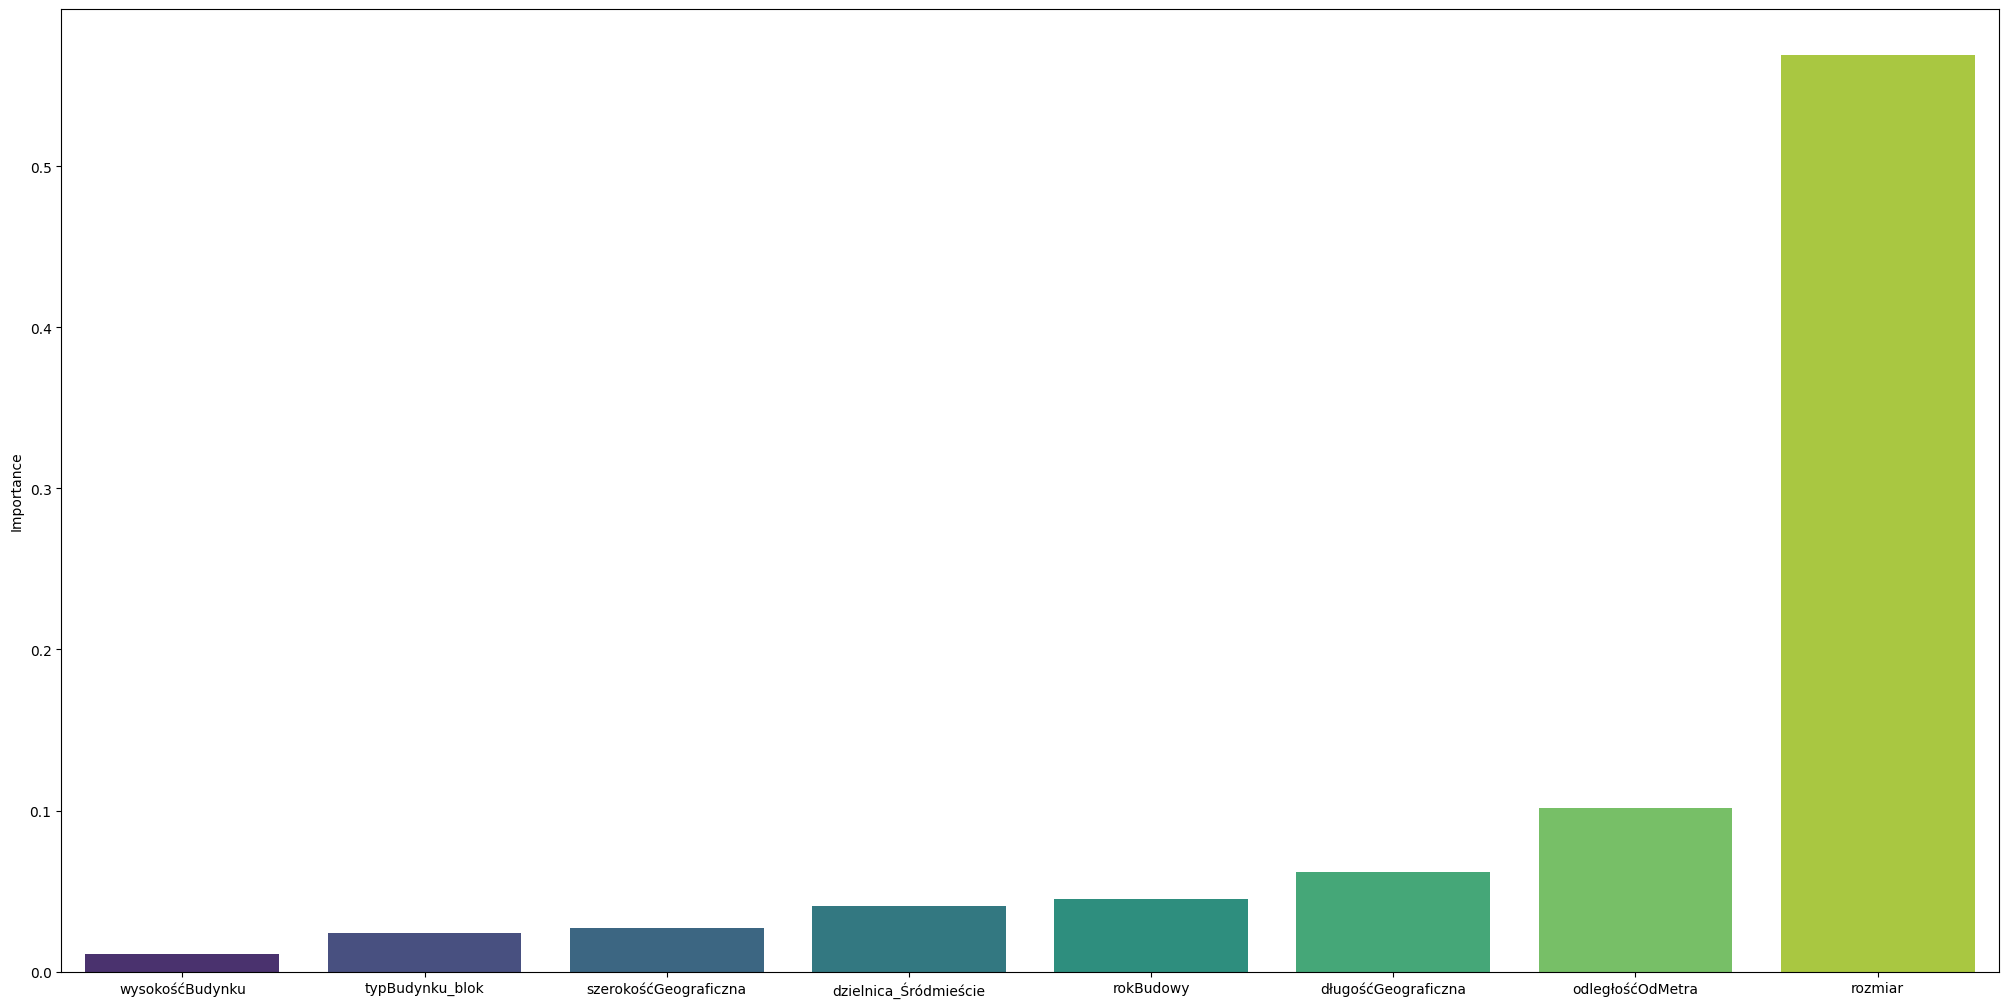

In [55]:
getPlotForFeatureScores(X_W_O,gb_4)

# Model with selected features

In [28]:
dummies_df_wrf = df_w_o[['cena','czynsz','rozmiar','liczbaPokoi','rokBudowy','odległośćOdMetra','długośćGeograficzna','szerokośćGeograficzna',
                                    'wysokośćBudynku']]
# WRF - with reduced features
X_WRF= dummies_df_wrf.drop('cena',axis=1)
y_wrf = dummies_df_wrf['cena']

X_train_wrf, X_test_wrf, y_train_wrf, y_test_wrf = train_test_split(X_WRF, y_wrf, test_size=0.2, random_state=42)
X_train_trans_wrf = scaler.fit_transform(X_train_wrf)
X_test_trans_wrf = scaler.transform(X_test_wrf)

In [29]:
rf_5 = RandomForestRegressor(n_estimators=200,criterion='squared_error',max_features=0.33,max_depth=15)
rf_5 = getFittedModelWithScore(rf_1,X_train_trans_wrf,X_test_trans_wrf,y_train_wrf,y_test_wrf,"data with selected features")

ab_5 = AdaBoostRegressor(dtForAdaBoost, learning_rate= 0.01, loss= 'exponential', n_estimators= 100)
ab_5 = getFittedModelWithScore(ab_5,X_train_trans_wrf,X_test_trans_wrf,y_train_wrf,y_test_wrf,"data with selected features")

gb_5 = GradientBoostingRegressor(n_estimators=300,learning_rate=0.01,loss='squared_error',max_depth=10)
gb_5 = getFittedModelWithScore(gb_5,X_train_trans_wrf,X_test_trans_wrf,y_train_wrf,y_test_wrf,"data with selected features")

svr_5 = SVR(C=5000000,epsilon=1e-06,gamma='auto',kernel='rbf')
svr_5 = getFittedModelWithScore(svr_5,X_train_trans_wrf,X_test_trans_wrf,y_train_wrf,y_test_wrf,"data with selected features")

y_pred_combined_5 = (rf_5.predict(X_test_trans_wrf)+ab_5.predict(X_test_trans_wrf)+gb_5.predict(X_test_trans_wrf)+svr_5.predict(X_test_trans_wrf))/4
addResultsForHybridModel(y_test_wrf,y_pred_combined_5,"data with selected features")

# Results

In [30]:
RMSE

['RandomForestRegressor RMSE score on unscaled data with outliers: 665776.0529350078',
 'RandomForestRegressor RMSE score on scaled data with outliers: 604371.1731834556',
 'RandomForestRegressor RMSE score on unscaled data without outliers: 144885.84195848767',
 'RandomForestRegressor RMSE score on scaled data without outliers: 145275.05373917473',
 'AdaBoostRegressor RMSE score on unscaled data with outliers: 599120.1116479407',
 'AdaBoostRegressor RMSE score on scaled data with outliers: 640794.8511238839',
 'AdaBoostRegressor RMSE score on unscaled data without outliers: 143680.78427169236',
 'AdaBoostRegressor RMSE score on scaled data without outliers: 143275.19102337913',
 'GradientBoostingRegressor RMSE score on unscaled data with outliers: 619524.530346991',
 'GradientBoostingRegressor RMSE score on scaled data with outliers: 623044.3290791991',
 'GradientBoostingRegressor RMSE score on unscaled data without outliers: 151298.2208011768',
 'GradientBoostingRegressor RMSE score 

In [31]:
RMSLE

['RandomForestRegressor RMSLE score on unscaled data with outliers: 0.17156159854410644',
 'RandomForestRegressor RMSLE score on scaled data with outliers: 0.16949859404040074',
 'RandomForestRegressor RMSLE score on unscaled data without outliers: 0.13440115285649742',
 'RandomForestRegressor RMSLE score on scaled data without outliers: 0.134713521949242',
 'AdaBoostRegressor RMSLE score on unscaled data with outliers: 0.16715912347318299',
 'AdaBoostRegressor RMSLE score on scaled data with outliers: 0.17098565507940766',
 'AdaBoostRegressor RMSLE score on unscaled data without outliers: 0.13033986446970808',
 'AdaBoostRegressor RMSLE score on scaled data without outliers: 0.13021978979083418',
 'GradientBoostingRegressor RMSLE score on unscaled data with outliers: 0.16931796448255815',
 'GradientBoostingRegressor RMSLE score on scaled data with outliers: 0.1692776520374615',
 'GradientBoostingRegressor RMSLE score on unscaled data without outliers: 0.13791785572036389',
 'GradientBo

In [32]:
MAPE

['RandomForestRegressor MAPE score on unscaled data with outliers: 0.12511796031352032',
 'RandomForestRegressor MAPE score on scaled data with outliers: 0.12425336262987048',
 'RandomForestRegressor MAPE score on unscaled data without outliers: 0.1022704201692551',
 'RandomForestRegressor MAPE score on scaled data without outliers: 0.10248150789246432',
 'AdaBoostRegressor MAPE score on unscaled data with outliers: 0.11299781381901962',
 'AdaBoostRegressor MAPE score on scaled data with outliers: 0.11569563862527332',
 'AdaBoostRegressor MAPE score on unscaled data without outliers: 0.092908997883329',
 'AdaBoostRegressor MAPE score on scaled data without outliers: 0.09287857547445671',
 'GradientBoostingRegressor MAPE score on unscaled data with outliers: 0.12339980815289205',
 'GradientBoostingRegressor MAPE score on scaled data with outliers: 0.12326508387127583',
 'GradientBoostingRegressor MAPE score on unscaled data without outliers: 0.10403239315506603',
 'GradientBoostingRegre